# Predicting Ames Housing Sales - One Hot Encoder

#### Jump To:
- [Creating Features](#feat)
    - [Polynomial Features](#poly)
- [One Hot Encoding](#one_hot)
- [Modeling](#model)
    - [Linear Regression](#lr)
    - [LassoCV](#lasso)
    - [RidgeCV](#ridge)
    - [Lasso GridSearch](#lassogs)

### Imports 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Lasso, ridge, LinearRegression, LassoCV, ElasticNetCV, RidgeCV, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

import statsmodels.api as sm

C:\Users\spank\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.linear_model.ridge module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


### Reading in our datasets
- train and test csv were cleaned and resaved in 'Ames-Training-Data-EDA-Feature.ipynb'

In [2]:
train_df = pd.read_csv('../datasets/train_clean.csv')
test_df = pd.read_csv('../datasets/test_clean.csv')

<a id='feat'></a>
### Selecting my features

In [3]:
train_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Mo Sold,Yr Sold,Sale Type,SalePrice,Has Pool,Has Fence,Has Fireplace,Finished Basement,Total Bath,Total SF
0,109,533352170,60,RL,69.0,13517,Pave,0,IR1,Lvl,...,3,2010,WD,130500,0,0,0,1,2.5,2204.0
1,544,531379050,60,RL,43.0,11492,Pave,0,IR1,Lvl,...,4,2009,WD,220000,0,0,1,1,3.5,3035.0
2,153,535304180,20,RL,68.0,7922,Pave,0,Reg,Lvl,...,1,2010,WD,109000,0,0,0,1,2.0,2114.0
3,318,916386060,60,RL,73.0,9802,Pave,0,Reg,Lvl,...,4,2010,WD,174000,0,0,0,1,2.5,1828.0
4,255,906425045,50,RL,82.0,14235,Pave,0,IR1,Lvl,...,3,2010,WD,138500,0,0,0,1,2.0,2121.0


In [4]:
test_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Misc Val,Mo Sold,Yr Sold,Sale Type,Has Pool,Has Fence,Has Fireplace,Finished Basement,Total Bath,Total SF
0,2658,902301120,190,RM,69.0,9142,Pave,1,Reg,Lvl,...,0,4,2006,WD,0,0,0,1,2.0,2948
1,2718,905108090,90,RL,70.0,9662,Pave,0,IR1,Lvl,...,0,8,2006,WD,0,0,0,1,2.0,3934
2,2414,528218130,60,RL,58.0,17104,Pave,0,IR1,Lvl,...,0,9,2006,New,0,0,1,1,3.5,2150
3,1989,902207150,30,RM,60.0,8520,Pave,0,Reg,Lvl,...,0,7,2007,WD,0,0,0,1,1.0,1936
4,625,535105100,20,RL,70.0,9500,Pave,0,IR1,Lvl,...,0,7,2009,WD,0,0,1,1,2.5,2788


I will be using the entire dataset, but I'd like to also make some polynomial features of selected categories

In [5]:
feat = ['Overall Qual', # overall qual of home
    'Total SF', # total SF of home inc basement
    'Gr Liv Area', # total sf of 1st & 2nd floor
    'Garage Area', # sf of garage 
    'Total Bath', # total baths in house
    'Year Built'] # Year built

train_df_X = train_df[feat]
test_df_X = test_df[feat]

<a id='poly'></a>
#### Polynomial Features
- Creating some interaction terms based on the features selected above only

In [6]:
poly = PolynomialFeatures(include_bias=False)

X_poly = poly.fit_transform(train_df_X)
#For Test dataset too
X_poly_test = poly.fit_transform(test_df_X)

In [7]:
# Creating a dataframe of the polynomial features
train_df_poly = pd.DataFrame(X_poly, columns = poly.get_feature_names(feat)) 
test_df_poly = pd.DataFrame(X_poly_test, columns = poly.get_feature_names(feat))

In [8]:
#Adding the polynomial features to our original dataset
train_poly_df = pd.concat([train_df, train_df_poly], axis=1)
test_poly_df = pd.concat([test_df, test_df_poly], axis=1)

In [9]:
# Removing duplicated columns, (The original columns that were used to create the Polynomial Features)
train_poly_df = train_poly_df.loc[:,~train_poly_df.columns.duplicated()]
test_poly_df = test_poly_df.loc[:,~test_poly_df.columns.duplicated()]

<a id='one_hot'></a>
### One- Hot Encoding
- Dummifying all categorical data, let's see what we get with the Kitchen Sink

In [10]:
train_df_dummies = pd.get_dummies(train_poly_df)
test_df_dummies = pd.get_dummies(test_poly_df)
test_df_dummies.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Alley,Overall Qual,Overall Cond,Year Built,Year Remod/Add,...,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD
0,2658,902301120,190,69.0,9142,1,6,8,1910,1950,...,0,0,0,0,0,0,0,0,0,1
1,2718,905108090,90,70.0,9662,0,5,4,1977,1977,...,0,0,0,0,0,0,0,0,0,1
2,2414,528218130,60,58.0,17104,0,7,5,2006,2006,...,0,0,0,0,0,0,1,0,0,0
3,1989,902207150,30,60.0,8520,0,5,6,1923,2006,...,0,0,0,0,0,0,0,0,0,1
4,625,535105100,20,70.0,9500,0,6,5,1963,1963,...,0,0,0,0,0,0,0,0,0,1


The purpose of this part is to create equal amounts of columns on both datasets for prediction purposes, new columns will be made with the value of 0 in all

In [11]:
train_col_difs = list(set(train_df_dummies.columns) - set(test_df_dummies.columns))
train_col_difs.remove('SalePrice')

In [12]:
for col in train_col_difs:
    test_df_dummies[col] = 0

In [13]:
test_col_difs = list(set(test_df_dummies.columns) - set(train_df_dummies.columns))
for col in test_col_difs:
    train_df_dummies[col] = 0

<a id='model'></a>
### Modeling
This is where I'll start to set up my x and y, train/test split, StandardScaler and some functions for ease

In [14]:
# selecting my X and y
X = train_df_dummies.drop(['SalePrice'], axis = 1)
y = train_df_dummies.SalePrice

In [15]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
#Standard Scaler
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

test_sc = ss.fit_transform(test_df_dummies)

In [17]:
## Creating a function that takes the features that we selected from test_c.csv
# Makes a prediction based on which model we used
# Creates a new DF with ID and SalesPrice prediction for that model 
# Saves it as a csv to be submitted

def preds_to_csv(file_name, model, test_X):
    preds = model.predict(test_X) # creating the prediction based on features
    
    to_submit = pd.DataFrame() # Create a new empty DF 
    to_submit['Id'] = test_poly_df['Id'] # creating a new column with ID
    to_submit['SalePrice'] = preds # creating a new column with our Sales Predictions
    
    to_submit.to_csv(file_name, index=False) #creating a new csv to be submitted to Kaggle

In [18]:
# Creating a function that outputs the score for my models
def scores(X_train, y_train, X_test, y_test, model):
    
    model = model.fit(X_train, y_train) # fitting the model
    y_preds = model.predict(X_test) #predicting the model off test split
    y_preds_train = model.predict(X_train) # predicting the model off train split
    
    # scoring
    print('Train Score: ', model.score(X_train, y_train))
    print('Test Score: ', model.score(X_test, y_test))
    print('')
    print('R2: ', r2_score(y_test, y_preds))
    print('MAE: ', mean_absolute_error(y_test, y_preds))
    print('MSE: ', mean_squared_error(y_test, y_preds))
    print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_preds_train)))
    print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_preds)))

<a id='lr'></a>
#### Linear Regression

In [19]:
lr = LinearRegression()

In [20]:
cross_val_score(lr,X,y, cv=5).mean()

0.7746603879686779

In [21]:
scores(X_train, y_train, X_test, y_test, lr)

Train Score:  0.9576435083874703
Test Score:  0.9166341200844322

R2:  0.9166341200844322
MAE:  15247.028627960175
MSE:  511868564.3457163
Train RMSE:  16367.17715237703
Test RMSE:  22624.512466475742


- Way overfitted

<a id='lasso'></a>
#### LassoCV

In [22]:
lasso = LassoCV()
scores(X_train_sc, y_train, X_test_sc, y_test, lasso)

Train Score:  0.9342913108242047
Test Score:  0.9280601582521963

R2:  0.9280601582521963
MAE:  14421.644389391917
MSE:  441712407.42616814
Train RMSE:  20385.67962480162
Test RMSE:  21016.95523681221


- Great RMSE and score comparison between train and test scores, I am optimistic
- Will do a GridSearch to find best alpha

In [23]:
# preds_to_csv('./datasets/Kaggle Submissions/lassocv_1h.csv', lasso, test_sc)

<a id='ridge'></a>
#### RidgeCV

In [24]:
ridge = RidgeCV()
scores(X_train_sc, y_train, X_test_sc, y_test, ridge)

Train Score:  0.9573316884658397
Test Score:  0.9182908650213039

R2:  0.9182908650213039
MAE:  15057.571774044056
MSE:  501696109.4615069
Train RMSE:  16427.312602454072
Test RMSE:  22398.5738265075


- Again, overfit, big gap between train and test scores

<a id ='lassogs'></a>
#### Lasso GridSearch

In [25]:
lasso_params = {
    'alpha' : range(100, 1051, 1), # start at 100 alpha, go up to 1050 and do 1 step
}

In [26]:
lasso1h_gridsearch = GridSearchCV(Lasso(),
                               lasso_params,
                               cv=5,
                               verbose = 1,
                               n_jobs=-1)

### RUN AT OWN  RISK! 
- The GridSearch: Fit 5 folds for each of 951 candidates, totalling 4755 fits
    - Took 3.4 min for me
- The output:
|   |   |   | 
|---|---|---|
|Train Score:|   |0.9383492649018759   |
|Test Score:|  | 0.9294985289075809 |
|R2:   |   |0.9294985289075809   |
|MAE:|   |14260.854377947337|
|MSE:|  | 432880776.0307536 |
|Train RMSE: | |19746.172315707885|
|Test RMSE:  |   |20805.787080299404 |

        - Best score : 0.8023093685432408
        - Best params : {'alpha': 1050}

In [28]:
scores(X_train_sc, y_train, X_test_sc, y_test, lasso1h_gridsearch)

Fitting 5 folds for each of 951 candidates, totalling 4755 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4755 out of 4755 | elapsed:  3.4min finished


Train Score:  0.9383492649018759
Test Score:  0.9294985289075809

R2:  0.9294985289075809
MAE:  14260.854377947337
MSE:  432880776.0307536
Train RMSE:  19746.172315707885
Test RMSE:  20805.787080299404


In [29]:
lasso1h_gridsearch.best_score_

0.8023093685432408

In [30]:
lasso1h_gridsearch.best_params_

{'alpha': 1050}

In [ ]:
#preds_to_csv('./datasets/Kaggle Submissions/lassogs_1h_tryagain.csv', lasso1h_gridsearch, test_sc)

In [32]:
ls = Lasso(alpha = 1050)

In [33]:
scores(X_train_sc, y_train, X_test_sc, y_test, ls)

Train Score:  0.9383492649018759
Test Score:  0.9294985289075809

R2:  0.9294985289075809
MAE:  14260.854377947337
MSE:  432880776.0307536
Train RMSE:  19746.172315707885
Test RMSE:  20805.787080299404


In [35]:
print(f'The Average SalePrice in our predicted model is ${ls.intercept_.round(2)}')

The Average SalePrice in our predicted model is $181061.99


In [36]:
train_df_coef = pd.DataFrame((list(zip(poly.get_feature_names(X.columns), ls.coef_))),columns = ['Features', 'Coefficient'])
train_df_coef

,Features,Coefficient
0,Id,-0.000000
1,PID,-0.000000
2,MS SubClass,-87.233773
3,Lot Frontage,190.281268
4,Lot Area,4721.111415
5,Alley,-0.000000
6,Id^2,0.000000
7,Id PID,3640.509242
8,Id MS SubClass,2929.054823
9,Id Lot Frontage,3068.403995


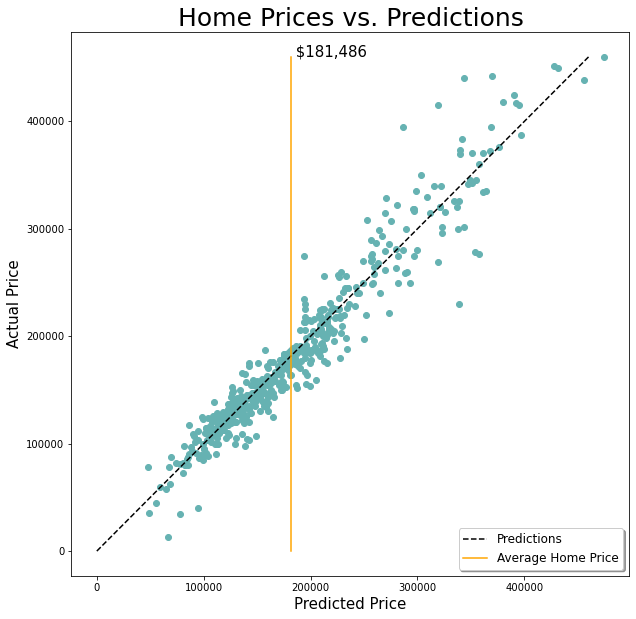

In [34]:
preds = ls.predict(X_test_sc) # predicting outside of the function

plt.figure(figsize=(10,10))
plt.scatter(preds, y_test, label=None, c='#66b2b2') # predictions and 'y_true of test split'

#lines
plt.plot((0, y_test.max()), (0,y_test.max()), 'k--', label='Predictions')
plt.plot((181486, 181486), (0,y_test.max()), '-', color='orange', label='Average Home Price')

plt.title('Home Prices vs. Predictions', fontsize=25)
plt.xlabel('Predicted Price', fontsize=15)
plt.ylabel('Actual Price', fontsize=15)

plt.annotate(' $181,486', (181486,y_test.max()), fontsize=15)

plt.legend(fontsize=12, loc='lower right', shadow='True');

### How EXCITING!!!
However putting it into Kaggle gave me the worst score at 39k
OUCH!

- This was mostly an experimental try, there are way too many columns in each dataset.
- The train dataset scores were pretty good and I decided to continue on and submit at the end, had I submitted at LassoCV I would have seen that I was on the wrong track for the test dataset and approached attempt 3.


- So far Attempt one (Notebooks labeled OG) have had the best results both in the training and testing dataset